# HW - 4 - CNN

Görev : PDF içerisinde verilen CNN mimarisinin oluşturulması ve
bu modeli eğitim/validasyon/test veri kümeleri üzerinde eğitmek/değerlendirmek. Modelin aktivasyon fonksiyonu olarak **Mish** kullanılacaktır. Eğitim sonucunda model kaydedilecek ve performansı metriklerle değerlendirilecektir.

Parametreler ve Diğer:

  model.compile içinm bunları kullanacağız

* Optimizer: Adam, Learning rate = 1e-3, batch-size=16, epoch=50

* scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=
[20, 40], gamma=0.3)

1. Train edilerek model save edilecek
2. Save edilen model yüklenerek test verisetinde kullanılacak
3. Confisuon matrix, accuracy, f-score ve auc score'laroı gösterilecek.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os


Mish aktivasyon fonksiyonu. Aşağıdaki kaynaktan yararlanılmıştır.  

* https://paperswithcode.com/method/mish

In [3]:
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))


### CNN Mimarisinin oluşturulması

PDF içerisinde istenen CNN mimarisinin detayına bakıldığında :

- Girişte 3RGB 224x224 görüntüler input olarak alınır.
- İlk iki evrede, sırasyıla konvolüsyon ve activation katmanları bulunur. İkinci konvolüsyon katmanından sonra  pooling (MaxPool) ve dropout (0.3 oranında) uygulanır.
- Üçüncü ve dördüncü konvolüsyon katmanları sırasıyla aynı şekilde tekrar eder. Dördüncü katmandan sonra tekrar MaxPool ve dropout (0.4 oranında) kullanılmıştır.
- Konvolüsyon katmanlarından sonra elde edilen çıktı yapay sinir ağı olan (fully connected) iki katmana aktarılır. Bu katmanlara gelmeden düzenleştirme (flatten) uygulanması gerekebilir.
- Son aşamada ise softmax aktivasyon fonksiyonundan geçirilerek sonuç elde edilir.



In [4]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)     # ilk katman
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)    # ikinci katmsn
        self.dropout1 = nn.Dropout(0.3)                 # dropout katmanı (%30)
        self.pool = nn.MaxPool2d(2, 2)                  # Pooling katmanı (2x2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)   # üçüncü katman
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # dördüncü katman
        self.dropout2 = nn.Dropout(0.4)                 # dropout katmanı  (%40)

        self.fc1 = nn.Linear(256 * 56 * 56, 256)    # tam boyutlu bağlantı katmanı
        self.fc2 = nn.Linear(256, num_classes)      # sonuç sınıf sayısı
        self.act = Mish()                           # aktivasyon fonksiyonu

    def forward(self, x):
        x = self.act(self.conv1(x))                 # ilk conv katmanı ve çıktısının aktivasyona verilmesi
        x = self.pool(self.act(self.conv2(x)))      # ikinci conv katmanı, çıktının aktivasyon ve poolinge verilmesi
        x = self.dropout1(x)                        # dropout katmanı (%30)
        x = self.act(self.conv3(x))                 # üçüncü conv katmanı ve çıktısının aktivasyona verilmesi
        x = self.pool(self.act(self.conv4(x)))      # dördüncü conv katmanı, çıktının aktivasyon ve poolinge verilmesi
        x = self.dropout2(x)                        # dropout katmanı (%40)
        x = x.view(x.size(0), -1)                   # Flattening işlemi {-1 boyutunu otomatik ayarlar}
        x = self.fc1(x)                             # full connected katmanı
        x = self.fc2(x)                             # son full connected katmanı
        return x


Drive içerisinden veri okuma için

In [5]:
# data_dir = "CaltechTinySplit"

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Example: Accessing a file in your Google Drive's "Colab Notebooks" folder
# data_dir = "/content/drive/MyDrive/Makale-Döküman-Makale Çalışmaları/YL Dersler/Derin Öğrenme Uygulamaları/HW/HW4-CNN/CaltechTinySplit" # Replace with your file path


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Okunan resimin 224 x 224 boyutunda olması için resize yapılır.

İlk olarak tüm görüntüler `224x224` boyutuna yeniden boyutlandırılır ve tensöre çevrilir. Bu işlem `transforms.Compose` aracılığıyla tanımlanmıştır.

`datasets.ImageFolder` kullanılarak `train`, `val` ve `test` klasörlerindeki görüntüler sınıf etiketleriyle birlikte yüklenir. Bu yapı, her alt klasörü bir sınıf olarak tanır ve ona göre etiketler oluşturur.

Veriler `DataLoader` aracılığıyla mini-batch’ler hâlinde belleğe alınmak üzere hazırlanır. Eğitim veri kümesi karıştırılır (`shuffle=True`), doğrulama ve test veri kümeleri ise sıralı olarak yüklenir.


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_ds = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_ds = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)


Train için fonksiyon oluşturulur.

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    model.train()
    for ep in range(num_epochs):
        total, correct, loss_sum = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            _, pred = torch.max(out, 1)
            total += y.size(0)
            correct += (pred == y).sum().item()
            loss_sum += loss.item()
        scheduler.step()
        print(f"Epoch {ep+1}/{num_epochs} - Loss: {loss_sum:.4f} - Acc: {100*correct/total:.2f}%")


In [8]:
def evaluate(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            prob = F.softmax(out, dim=1)
            _, pred = torch.max(prob, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
            y_prob.extend(prob.cpu().numpy())
    return y_true, y_pred, np.array(y_prob)


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel(len(train_ds.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.3)

train_model(model, criterion, optimizer, scheduler)
torch.save(model.state_dict(), 'cnn_mish_model.pt')


Epoch 1/50 - Loss: 403.5346 - Acc: 65.01%
Epoch 2/50 - Loss: 53.3376 - Acc: 83.80%
Epoch 3/50 - Loss: 26.2889 - Acc: 89.67%
Epoch 4/50 - Loss: 18.3249 - Acc: 92.79%
Epoch 5/50 - Loss: 6.4313 - Acc: 98.22%
Epoch 6/50 - Loss: 3.2802 - Acc: 98.96%
Epoch 7/50 - Loss: 1.2963 - Acc: 99.70%
Epoch 8/50 - Loss: 6.0624 - Acc: 98.14%
Epoch 9/50 - Loss: 27.8444 - Acc: 92.20%
Epoch 10/50 - Loss: 7.4570 - Acc: 97.62%
Epoch 11/50 - Loss: 1.2554 - Acc: 99.70%
Epoch 12/50 - Loss: 0.1298 - Acc: 100.00%
Epoch 13/50 - Loss: 0.0527 - Acc: 100.00%
Epoch 14/50 - Loss: 0.0219 - Acc: 100.00%
Epoch 15/50 - Loss: 0.0201 - Acc: 100.00%
Epoch 16/50 - Loss: 0.0153 - Acc: 100.00%
Epoch 17/50 - Loss: 0.0129 - Acc: 100.00%
Epoch 18/50 - Loss: 0.0108 - Acc: 100.00%
Epoch 19/50 - Loss: 0.0095 - Acc: 100.00%
Epoch 20/50 - Loss: 0.0085 - Acc: 100.00%
Epoch 21/50 - Loss: 0.0083 - Acc: 100.00%
Epoch 22/50 - Loss: 0.0076 - Acc: 100.00%
Epoch 23/50 - Loss: 0.0073 - Acc: 100.00%
Epoch 24/50 - Loss: 0.0069 - Acc: 100.00%
Epoch 

Accuracy: 0.8793, F1: 0.8713, AUC: 0.980772327731886


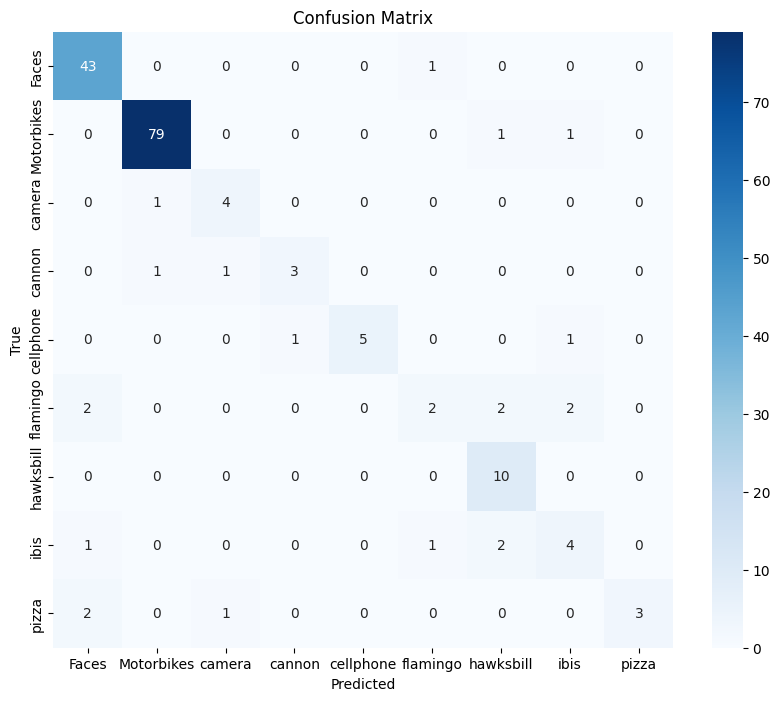

In [10]:
model.load_state_dict(torch.load('cnn_mish_model.pt'))
y_true, y_pred, y_prob = evaluate(model, test_loader)

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
try:
    auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
except:
    auc = 'AUC hesaplanamadı'

print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, AUC: {auc}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_ds.classes, yticklabels=train_ds.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
